# 3 Exploratory Data Analysis<a id='3_Exploratory_Data_Analysis'></a>

## 3.1 Contents<a id='3.1_Contents'></a>
* [3 Exploratory Data Analysis](#3_Exploratory_Data_Analysis)
  * [3.1 Contents](#3.1_Contents)
  * [3.2 Introduction](#3.2_Introduction)
  * [3.3 Imports](#3.3_Imports)
  * [3.4 Load The Data](#3.4_Load_The_Data)
  * [3.5 Explore The Data](#3.5_Explore_The_Data)
    * [3.5.1 Perfume usage Gender-wise](#3.5.1_gender_wise)
    * [3.5.2 Popular Notes in Perfumes](#3.5.2_Perfume_Notes)
      * [3.5.2.1 Collate Top/Middle/Base Notes](#3.5.2.1_Coallate_Notes)
      * [3.5.2.2 Pick out commonly used notes in perfumes](#3.5.2.2_Top_Notes)
      * [3.5.2.3 Visualize top 25 Notes by gender](#3.5.2.3_Top_25_gender)
      * [3.5.2.4 Note Preference per gender](#3.5.2.4_Note_per_gender)
  * [3.6 Summary](#3.6_Summary)

## 3.2 Introduction<a id='3.2_Introduction'></a>

We have data scraped from [fragrantica](https://www.fragrantica.com/) website which will help us determine the gender to market a new perfume to.

The most important factor of a perfume are the _notes_ that make it up. We will feed a set of notes to our model and will be informed if the perfume will suit

- female
- male

The data has been cleaned up.  We would like to do some initial exploration to understand how perfumes are recived across the gender spectrum.

## 3.3 Imports<a id='3.3_Imports'></a>

In [318]:
import pandas as pd
import numpy as np
import missingno as msno
import re 
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from scipy.stats import zscore


## 3.4 Load The Data<a id='3.4_Load_The_Data'></a>

In [319]:
perfume_data = pd.read_csv('../data/interim/perfume_labeled.csv')
df = perfume_data.copy()

In [320]:
df.shape

(47649, 22)

In [321]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47649 entries, 0 to 47648
Data columns (total 22 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     47649 non-null  object
 1   notes_1   45424 non-null  object
 2   notes_2   43905 non-null  object
 3   notes_3   41122 non-null  object
 4   notes_4   38243 non-null  object
 5   notes_5   34903 non-null  object
 6   notes_6   31169 non-null  object
 7   notes_7   27265 non-null  object
 8   notes_8   22753 non-null  object
 9   notes_9   16563 non-null  object
 10  notes_10  12322 non-null  object
 11  notes_11  9188 non-null   object
 12  notes_12  6678 non-null   object
 13  notes_13  5000 non-null   object
 14  notes_14  3756 non-null   object
 15  notes_15  2899 non-null   object
 16  notes_16  2242 non-null   object
 17  notes_17  1712 non-null   object
 18  notes_18  1312 non-null   object
 19  notes_19  992 non-null    object
 20  notes_20  763 non-null    object
 21  label     47

In [322]:
df.head()

,title,notes_1,notes_2,notes_3,notes_4,notes_5,notes_6,notes_7,notes_8,notes_9,...,notes_12,notes_13,notes_14,notes_15,notes_16,notes_17,notes_18,notes_19,notes_20,label
0,Aamal The Spirit of Dubai for women and men,Top1Bulgarian Rose,Top2Bergamot,Top3Fruits,Top4Agarwood (Oud),Middle0Sandalwood,Middle1Agarwood (Oud),Middle2Cypriol Oil or Nagarmotha,Middle3Benzoin,Base0Amber,...,Base3Moss,Base4Agarwood (Oud),Base5Indian Oud,NaN,NaN,NaN,NaN,NaN,NaN,men
1,Aatifa Ajmal for women and men,Top1Rose,Top2Cumin,Middle0Amber,NaN,Base0Musk,Base1Amber,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,women
2,AA Al-Jazeera Perfumes for women and men,Top1Rose,Top2Sandalwood,Top3Apple,Top4Agarwood (Oud),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unisex
3,aarewasser Art of Scent - Swiss Perfumes for w...,Top1Green Tea,Top2White Flowers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unisex
4,Aaliyah Hamidi Oud & Perfumes for women and men,Top1Amber,Top2Sandalwood,NaN,Top4Vetiver,Top5Saffron,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unisex


## 3.5 Explore The Data<a id='3.5_Explore_The_Data'></a>

### 3.5.1 Perfume usage Gender-wise<a id='3.5.1_gender_wise'></a>

We need to know how these perfumes were marketed. Which gender was the intended customer segment?

`title` column contains this information which can be retrieved to create a new `gender` column.

In [323]:
def find_gender(title):
    
    title = str(title)
    unisex_text1 = "women and men"
    unisex_text2 = "men and women"
    women_text = "women"
    men_text = "men"
    
    if unisex_text1 in title or unisex_text2 in title:
        return "unisex"
    elif women_text in title:
        return "women"
    elif men_text in title:
        return "men"
    else:
        return np.nan

In [324]:
df['gender'] = df.title.apply(find_gender)

In [325]:
df.gender.value_counts()

women     22137
unisex    16225
men        9149
Name: gender, dtype: int64

In [326]:
df.gender.unique()

array(['unisex', 'women', 'men', nan], dtype=object)

In [327]:
df.gender.isnull().sum()

138

We have **138** null values in our perfume. As most of the perfumes are marketed towards _women_, lets replace **nan** values with `women`. 

In [328]:
df.gender.fillna('women', inplace=True)
df.gender.isnull().sum()

0

##### What is the percentage of perfumes in the market under each gender?

We have two gender related information with us.
- The gender marketed at by the manufacturers
- The gender voted by customers

How much does it differ?

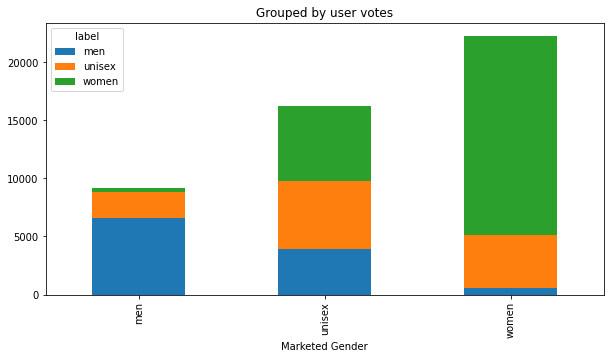

In [330]:
df_plot = df.groupby(['gender', 'label']).size().reset_index().pivot(columns='label', index='gender', values=0)
df_plot.plot(kind='bar', stacked=True, figsize=(10,5))
plt.title('Grouped by user votes')  
plt.xlabel('Marketed Gender')
plt.savefig('gender_label.png');

There are more perfumes available in the *women* segment than all other segments. Even perfumes that are marketed as *unisex* are generally voted as more suited to *women* than *men*.

In [354]:
# Check out the percentage values
print("Number of perfumes marketed for women:", len(df[df.gender == 'women']))
print("Breakup of perfumes as per votes:")
print(df[df.gender == 'women']['label'].value_counts())
print("\n")

print("Number of perfumes marketed for men:", len(df[df.gender == 'men']))
print("Breakup of perfumes as per votes:")
print(df[df.gender == 'men']['label'].value_counts())
print("\n")

print("Number of perfumes marketed for unisex:", len(df[df.gender == 'unisex']))
print("Breakup of perfumes as per votes:")
print(df[df.gender == 'unisex']['label'].value_counts())
print("\n")

Number of perfumes marketed for women: 22275
Breakup of perfumes as per votes:
women     17134
unisex     4600
men         541
Name: label, dtype: int64


Number of perfumes marketed for men: 9149
Breakup of perfumes as per votes:
men       6621
unisex    2228
women      300
Name: label, dtype: int64


Number of perfumes marketed for unisex: 16225
Breakup of perfumes as per votes:
women     6411
unisex    5897
men       3917
Name: label, dtype: int64




Have we got a balanced target feature?

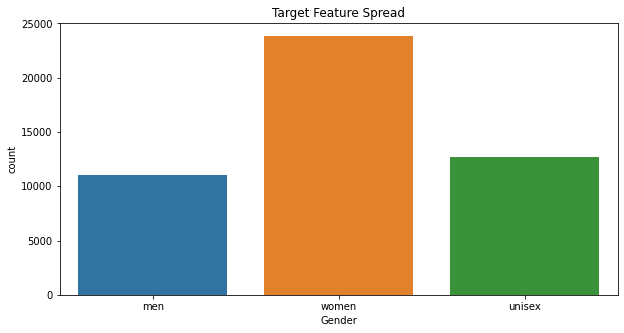

In [333]:
plt.figure(figsize=(10,5))
sns.countplot(x=df.label)
plt.title('Target Feature Spread')  
plt.xlabel('Gender')
plt.show();

### 3.5.2 Popular Notes in Perfumes<a id='3.5.2_Perfume_Notes'></a>

#### 3.5.2.1 Collate Top/Middle/Base Notes <a id='3.5.2.1_Coallate_Notes'></a>

In [334]:
# Get all note column as a single field.
notes_columns = ['notes_1', 'notes_2', 'notes_3', 'notes_4', 'notes_5', 
                 'notes_6', 'notes_7', 'notes_8', 'notes_9', 'notes_10', 
                 'notes_11', 'notes_12', 'notes_13', 'notes_14', 'notes_15', 
                 'notes_16', 'notes_17', 'notes_18', 'notes_19', 'notes_20']

Time to take a look at the `Notes` fields. At present they are split into individual columns. 

Let's group them into _Top/Middle/Base_ notes for further processing.

In [335]:
def parse_values(note_string, layer):
    substring = note_string[note_string.find(layer):note_string.find(',', note_string.rfind(layer))]
    substring = re.sub(layer, '', substring)
    return(re.sub(r'\d', '', substring))

In [336]:
df['notes'] = df[notes_columns].apply(lambda row: ','.join(row.values.astype(str)), axis=1)

df['notes'] = df['notes'] + " "

df['top_notes'] = df.notes.apply(parse_values, args= ('Top',))
df['middle_notes'] = df.notes.apply(parse_values, args= ('Middle',))
df['base_notes'] = df.notes.apply(parse_values, args= ('Base',))

df['notes'] = df['notes'].str.strip()

In [337]:
# Remove unneccessary values to get distinct Notes
df['top_notes'] = df['top_notes'].map(lambda x: re.sub(r'Top|Middle|Base|\d|\,nan|nan,|\(|\)', '', x), na_action='ignore')
df['middle_notes'] = df['middle_notes'].map(lambda x: re.sub(r'Top|Middle|Base|\d|\,nan|nan,|\(|\)', '', x), na_action='ignore')
df['base_notes'] = df['base_notes'].map(lambda x: re.sub(r'Top|Middle|Base|\d|\,nan|nan,|\(|\)', '', x), na_action='ignore')
df['notes'] = df['notes'].map(lambda x: re.sub(r'Top|Middle|Base|\d|\,nan|nan,|\(|\)', '', x), na_action='ignore')

In [338]:
df[['top_notes', 'middle_notes', 'base_notes','notes']]

,top_notes,middle_notes,base_notes,notes
0,"Bulgarian Rose,Bergamot,Fruits,Agarwood Oud","Sandalwood,Agarwood Oud,Cypriol Oil or Nagarmo...","Amber,Castoreum,Civet,Moss,Agarwood Oud,Indian...","Bulgarian Rose,Bergamot,Fruits,Agarwood Oud,Sa..."
1,"Rose,Cumin",Amber,"Musk,Amber","Rose,Cumin,Amber,Musk,Amber"
2,"Rose,Sandalwood,Apple,Agarwood Oud",,,"Rose,Sandalwood,Apple,Agarwood Oud"
3,"Green Tea,White Flowers",,,"Green Tea,White Flowers"
4,"Amber,Sandalwood,Vetiver,Saffron",,,"Amber,Sandalwood,Vetiver,Saffron"
...,...,...,...,...
47644,"Lavender,Coriander","Agarwood Oud,Myrrh,Labdanum,Incense","Patchouli,Sandalwood,Vanilla","Lavender,Coriander,Agarwood Oud,Myrrh,Labdanum..."
47645,Sage,"Mate,Rose,Jasmine,Orris","Cashmere Wood,Tonka Bean,Musk,Moss,Amber","Sage,Mate,Rose,Jasmine,Orris,Cashmere Wood,Ton..."
47646,Lemon,"Sage,Mint","Mahogany,Sandalwood,Amber","Lemon,Sage,Mint,Mahogany,Sandalwood,Amber"
47647,"Lemon,Ylang-Ylang","Jasmine,Cloves","Patchouli,White Musk","Lemon,Ylang-Ylang,Jasmine,Cloves,Patchouli,Whi..."


Verify that the notes have been properly grouped.

In [339]:
df.loc[47648, notes_columns]

notes_1             Top1Lemon
notes_2              Top2Pear
notes_3     Middle0Pink Peony
notes_4         Middle1Violet
notes_5          Middle2Lotus
notes_6        Base0Patchouli
notes_7       Base1Tonka Bean
notes_8             Base2Musk
notes_9                   NaN
notes_10                  NaN
notes_11                  NaN
notes_12                  NaN
notes_13                  NaN
notes_14                  NaN
notes_15                  NaN
notes_16                  NaN
notes_17                  NaN
notes_18                  NaN
notes_19                  NaN
notes_20                  NaN
Name: 47648, dtype: object

Reverify that all 'nan' values are removed.

In [340]:
df.loc[df.notes.str.contains(r'\bnan\b'), 'notes']

Series([], Name: notes, dtype: object)

All 'nan' values have been taken care of.

We have collected all the notes in a perfume to a single column. Let's save them as a list, rather than a comma separated string.

In [341]:
df['notes_list'] = df.notes.str.split(',')
df['top_notes_list'] = df.top_notes.str.split(',')
df['middle_notes_list'] = df.middle_notes.str.split(',')
df['base_notes_list'] = df.base_notes.str.split(',')

#### 3.5.2.2 Pick out commonly used notes in perfumes<a id='3.5.2.2_Top_Notes'></a>

A perfume is made up of distinct notes/smells. Let's collect all the distinct *notes* in our dataset.

In [342]:
#look for all disitnct notes in our dataset
notes_set = {note for row in df['notes'].astype(str) for note in row.split(',')}
len(notes_set)

1440

We have **1441** unique notes in our dataset. Let's get a count of each of these notes.

In [343]:
def get_count(label_count):
    
    labels = label_count.index.tolist()
    count = {}
    
    if 'women' in labels:
        count['women'] = label_count['women']
    else:
        count['women'] = 0
        
    if 'men' in labels:
        count['men'] = label_count['men']
    else:
        count['men'] = 0

    if 'unisex' in labels:
        count['unisex'] = label_count['unisex']
    else:
        count['unisex'] = 0
    
    return count

In [344]:
women_count= []
men_count= []
unisex_count= []

for note in notes_set:
    label_count = get_count(df.loc[df.notes_list.map(lambda x: True if note in x else False), 'label'].value_counts())
    women_count.append(label_count['women'])
    men_count.append(label_count['men'])
    unisex_count.append(label_count['unisex'])

note_count = pd.DataFrame({'note': list(notes_set), 'women': women_count, 'men': men_count, 'unisex': unisex_count})
note_count ['total'] = note_count[['women', 'men', 'unisex']].sum(axis=1)
note_count = note_count.sort_values(by='total', ascending=False).reset_index(drop=True)

#     plt.figure(figsize=(10,5))
#     sns.countplot(x=subset_df.gender, hue=subset_df['label'])
#     plt.title('Perfumes with '+ note + ' grouped by gender')  
#     plt.xlabel('Marketed Gender')
#     plt.show();

We cannot process these many notes. Let's only consider the notes that appear in 100 or more perfumes.

In [357]:
#final_notes = note_count.iloc[0:150,:]
final_notes = note_count[note_count.total >= 100]

In [358]:
final_notes.shape[0]

119

So we have **299** distinct notes that appear in 100 perfumes or more.

In [359]:
final_notes.tail(3)

,note,women,men,unisex,total
116,Orris,292,125,122,539
117,Frangipani,400,37,91,528
118,Blackberry,346,32,126,504


In [360]:
final_notes.head(10)

,note,women,men,unisex,total
0,Musk,9910,4084,4830,18824
1,Sandalwood,7050,3313,3421,13784
2,Jasmine,8010,2028,3415,13453
3,Amber,6180,3651,3484,13315
4,Patchouli,4862,3625,3241,11728
5,Rose,6626,1548,2732,10906
6,Vanilla,5838,1861,2954,10653
7,Cedar,3392,3099,2711,9202
8,Bergamot,3264,2146,1678,7088
9,Vetiver,2104,2474,1710,6288


**Musk** is the clear favourite, appearing in 18000+ perfumes. The top 10 notes appear in 6000 perfumes or more.

#### 3.5.2.3 Visualize top 25 Notes by gender<a id='3.5.2.3_Top_25_gender'></a>

Let's visualize top 25.

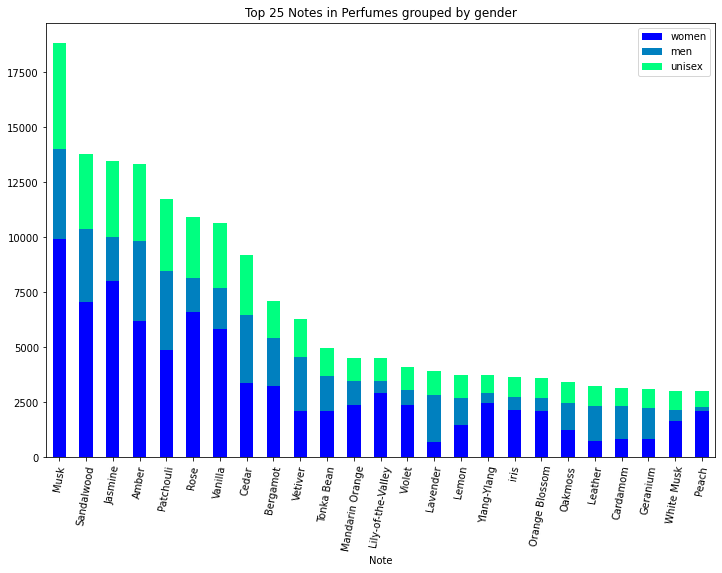

In [362]:
final_notes.iloc[0:25, 0:4].set_index('note').plot(kind='bar', stacked=True, figsize=(12,8), colormap='winter')
plt.title('Top 25 Notes in Perfumes grouped by gender')  
plt.xticks(rotation=80)
plt.xlabel('Note')
plt.savefig('top25_notes_by_gender.png');
plt.show();

There are some notes, like 'Musk' which is present more in Women's prefumes, while we also have some notes like 'Cardamom' that appear more in men's perfumes.

So there is a clear preference for specific notes by a gender.

#### 3.5.2.4 Note Preference per gender<a id='3.5.2.4_Note_per_gender'></a>

Are there some notes that appear more in men's perfumes than in female perfumes?

In [365]:
final_notes.query('men > women and men > unisex')

,note,women,men,unisex,total
9,Vetiver,2104,2474,1710,6288
14,Lavender,716,2114,1090,3920
19,Oakmoss,1230,1237,939,3406
20,Leather,761,1567,929,3257
21,Cardamom,830,1498,826,3154
22,Geranium,827,1437,849,3113
27,Agarwood Oud,660,1095,829,2584
28,Cinnamon,901,990,664,2555
32,Nutmeg,549,1161,634,2344
37,Labdanum,695,786,689,2170


There are only 30 notes that appear more in men's perfumes than in female perfumes.

## 3.6 Save File<a id='3.7_Save File'></a>

We now have two datasets that contain the details we need. Let's clean them up to have only relevant details.

In [295]:
df.columns

Index(['title', 'notes_1', 'notes_2', 'notes_3', 'notes_4', 'notes_5',
       'notes_6', 'notes_7', 'notes_8', 'notes_9', 'notes_10', 'notes_11',
       'notes_12', 'notes_13', 'notes_14', 'notes_15', 'notes_16', 'notes_17',
       'notes_18', 'notes_19', 'notes_20', 'label', 'gender', 'notes',
       'top_notes', 'middle_notes', 'base_notes', 'notes_list',
       'top_notes_list', 'middle_notes_list', 'base_notes_list'],
      dtype='object')

In [296]:
final_df = df.drop(columns=['notes_1', 'notes_2', 'notes_3', 'notes_4', 'notes_5',
       'notes_6', 'notes_7', 'notes_8', 'notes_9', 'notes_10', 'notes_11',
       'notes_12', 'notes_13', 'notes_14', 'notes_15', 'notes_16', 'notes_17',
       'notes_18', 'notes_19', 'notes_20', 'notes_list', 'label'])

In [297]:
final_df.columns

Index(['title', 'gender', 'notes', 'top_notes', 'middle_notes', 'base_notes',
       'top_notes_list', 'middle_notes_list', 'base_notes_list'],
      dtype='object')

In [298]:
final_df['label'] = df['label']
final_df.columns

Index(['title', 'gender', 'notes', 'top_notes', 'middle_notes', 'base_notes',
       'top_notes_list', 'middle_notes_list', 'base_notes_list', 'label'],
      dtype='object')

In [299]:
final_notes.columns

Index(['note', 'women', 'men', 'unisex', 'total'], dtype='object')

The datasets are ready to be saved.

In [300]:
datapath = '../data/interim/'
datapath_perfumedata = os.path.join(datapath, 'perfume_data_step3_features.csv')
if not os.path.exists(datapath_perfumedata):
   final_df.to_csv(datapath_perfumedata, index=False)

Let's also save the `Notes` information we collected as a separate csv file.

In [301]:
datapath_perfumedata = os.path.join(datapath, 'perfume_notes_columns.csv')
if not os.path.exists(datapath_perfumedata):
    final_notes.to_csv(datapath_perfumedata, index=False)

## 3.7 Summary<a id='3.7_Summary'></a>

We started off with a dataset which had details about perfumes, mainly the notes of a perfume. We wish to predict the gender that will prefer a perfume given the perfume notes that make up the perfume.

For this we did the following.

1. Retrieved `gender` information from the `title` of a perfume.
2. Coallated notes into Top/Middle/Base columns
3. Identified all distinct `Notes` in our dataset - 1440.
4. Found the count of each `Note` in our dataset along with the count in a male/female perfume. This helped us to identify the most commonly used `Notes` in perfumes.
5. Picked all `Notes` that appear in 100 or more perfumes - we have **299** such `Notes`.

We can now use these datasets and proceed to pre-processing step.